<a href="https://colab.research.google.com/github/LucasVD23/Analise-de-Aprendizado-Semi-supervisionado/blob/main/T1_AM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Trabalho 1 de AM2**

*Integrantes:*

Lucas Vinícius Domingues 769699

Rafael Yoshio Yamawaki Murata 769681

Victor Luís Aguilar Antunes 769734

**Links para os Datasets utilizados:**
1. https://www.openml.org/d/1037
2. https://www.openml.org/d/1480
3. https://www.openml.org/d/481
4. https://www.openml.org/d/451
5. https://archive.ics.uci.edu/ml/datasets/Qualitative_Bankruptcy

# **Importando dados**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import random
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [ ]:
quant_bank = pd.read_csv("/content/Qualitative_Bankruptcy.data.txt")
ada_prior =  pd.read_csv("/content/ada_prior.csv")
biomed =  pd.read_csv("/content/biomed.csv")
ilpd = pd.read_csv("/content/ilpd.csv")
irish = pd.read_csv("/content/irish.csv")

In [ ]:
"""
Os datasets biomed e irish possuem alguns valores não inseridos codificados como "?" ou "NaN" que não seriam eleminados com dropna()
Portanto, é necessário retirar esses atributos, transformar em float as colunas que eram para serem numéricas e contínuas,
mas estavam como strings devido aos valores "?" ou "NaN" inseridos com strings
"""
for i in biomed.columns:
  biomed[i] = (biomed[biomed[i] != "?"])[i]
  biomed[i] = (biomed[biomed[i] != "NaN"])[i]

for i in irish.columns:
  irish[i] = (irish[irish[i] != "?"])[i]
  irish[i] = (irish[irish[i] != "NaN"])[i]

biomed["m2"] = biomed["m2"].astype(float)
biomed["m4"] = biomed["m4"].astype(float)
irish["Prestige_score"] = irish["Prestige_score"].astype(float)


In [ ]:

"""
A maior parte dos datasets possuia os valores de classes agrupados em uma parte do arquivo
(classe 0 na primeira metadde e classe 1 na segunda, por exemplo. Portanto, é necessário 
realizar um shuffle nos dados para que a distribuição das classes fique aleatória no arquivo.
Isso é feito retirando um sample aleatório do tamanho do dataset em cada dataset)
"""
quant_bank = quant_bank.sample(frac=1).reset_index(drop=True).dropna()
ada_prior = ada_prior.sample(frac=1).reset_index(drop=True).dropna()
biomed = biomed.sample(frac=1).reset_index(drop=True).dropna()
ilpd = ilpd.sample(frac=1).reset_index(drop=True).dropna()
irish = irish.sample(frac=1).reset_index(drop=True).dropna()

ada_prior = ada_prior.drop(columns = ['education'] ) #retirando atributo redundate de ada_prior, já existe um atributo representando a mesma coisa("educationNum")


In [ ]:
#reordenando dataset irish para a classe ficar na última coluna
irish = irish[['Sex', 'DVRT', 'Educational_level', 'Prestige_score', 'Type_school', 'Leaving_Certificate']] 

In [ ]:
quant_bank.columns,ada_prior.columns,biomed.columns,ilpd.columns,irish.columns #mostrando as colunas de cada dataset

(Index(['P', 'P.1', 'A', 'A.1', 'A.2', 'P.2', 'NB'], dtype='object'),
 Index(['age', 'workclass', 'fnlwgt', 'educationNum', 'maritalStatus',
        'occupation', 'relationship', 'race', 'sex', 'capitalGain',
        'capitalLoss', 'hoursPerWeek', 'nativeCountry', 'label'],
       dtype='object'),
 Index(['Observation_number', 'Hospital_identification_number_for_blood_sample',
        'Age_of_patient', 'Date_that_blood_sample_was_taken', 'ml', 'm2', 'm3',
        'm4', 'class'],
       dtype='object'),
 Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'Class'], dtype='object'),
 Index(['Sex', 'DVRT', 'Educational_level', 'Prestige_score', 'Type_school',
        'Leaving_Certificate'],
       dtype='object'))

In [ ]:
classes = {'quant_bank':'NB','ada_prior':'label','biomed':'class','ilpd':'Class','irish':'Leaving_Certificate'}  #dicionário marcando as classes dos datasets

In [ ]:
datasets = {'quant_bank':quant_bank,'ada_prior': ada_prior,'biomed':biomed, 'ilpd': ilpd, 'irish': irish} #dicionário com todos os datasets

# **EDA**

### **Regras de decisão a partir de dados qualitativos de falência usando algoritmos genéticos**

1. Risco Industrial: {P,A,N}
2. Risco de Gestão: {P,A,N}
3. Flexibilidade Financeira: {P,A,N}
4. Credibilidade: {P,A,N}
5. Competitividade: {P,A,N}
6. Risco Operacional: {P,A,N}
7. Classe: {B,NB}

(P = Positivo, A = Médio, N = Negativo, B = Falência, NB = Não-Falência)

In [ ]:
quant_bank.head(10)

,P,P.1,A,A.1,A.2,P.2,NB
0,P,A,P,N,P,N,NB
1,A,N,N,N,N,A,B
2,A,A,A,A,P,A,NB
3,P,N,N,N,A,A,B
4,P,N,N,N,N,N,B
5,P,P,A,P,P,N,NB
6,P,N,N,N,N,P,B
7,N,N,N,N,N,N,B
8,P,N,P,P,A,N,NB
9,P,P,A,P,A,P,NB


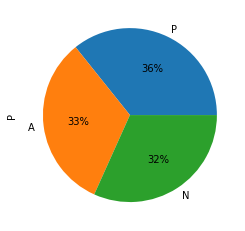

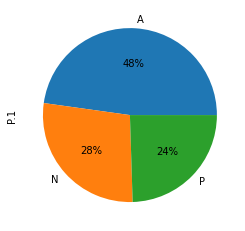

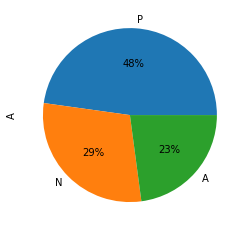

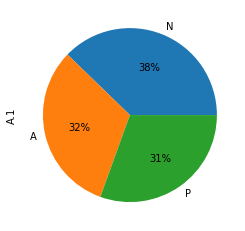

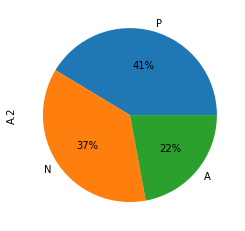

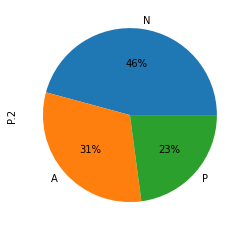

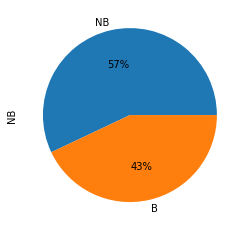

In [ ]:
quant_bank_attr = ['P', 'P.1', 'A',	'A.1', 'A.2',	'P.2',	'NB']

for atributo in quant_bank_attr:
  data = quant_bank[atributo].unique()
  plt.figure(figsize=(4,4))
  quant_bank[atributo].value_counts().plot.pie(labels = data, autopct='%1.0f%%')
  #plt.legend(loc="best")
  plt.show()

### **Descobrir pessoas de alta renda a partir de dados do censo**

1. Idade da instância (numérico)
2. Classe de trabalho da instância (nominal)
3. Peso de amostragem da instância (numérico)
4. Nível de educação da instância (nominal)
5. nível educacional da instância (versão numérica)
6. Estado civil da instância (nominal)
7. Ocupação da instância (nominal)
8. Tipo de relacionamento da instância (nominal)
9. Raça da instância (nominal)
10. Sexo da instância (nominal)
11. Ganho de capital da instância (numérico)
12. Perda de capital da instância (numérica)
13. Número de horas de trabalho da instância por semana (numérico)
14. País de origem da instância (numérico)
15. Atributo de classe do rótulo (1: a instância ganha mais de 50 mil por ano; caso contrário -1)

In [ ]:
ada_prior.head(10)


,age,workclass,fnlwgt,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,label
0,34,Federal-gov,400943,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,44,United-States,-1
1,53,Private,289620,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,?,1
2,18,Private,238401,10,Never-married,Sales,Own-child,White,Female,0,0,25,United-States,-1
3,30,Private,137076,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,1
4,28,Self-emp-inc,219705,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5013,0,55,United-States,-1
5,43,Private,132130,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,1
6,18,Private,338632,7,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,-1
7,29,Private,194197,13,Never-married,Exec-managerial,Own-child,White,Male,0,0,40,United-States,-1
8,48,Local-gov,142719,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,1
9,37,Private,187748,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,-1


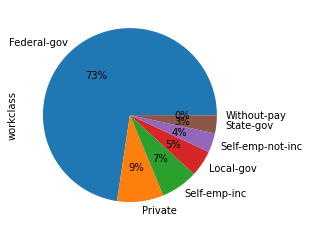

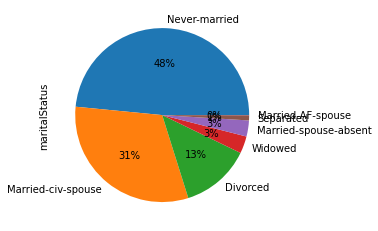

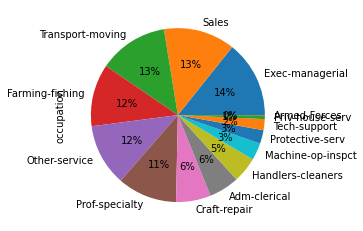

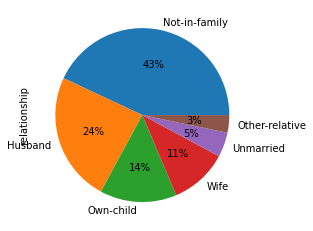

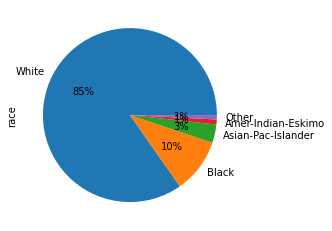

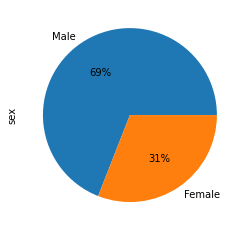

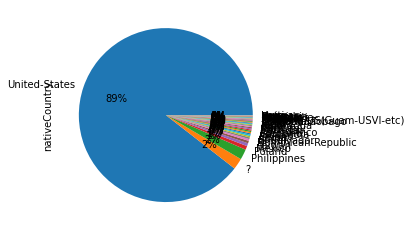

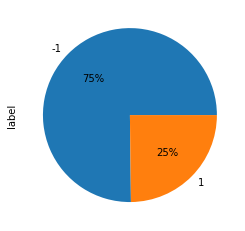

In [ ]:
#Visualizando os atributos nominais do dataset ada_prior
nominal_ada_prior = ['workclass', 'maritalStatus', 'occupation', 'relationship', 'race', 'sex', 'nativeCountry', 'label']

for atributo in nominal_ada_prior:
  data = ada_prior[atributo].unique()
  plt.figure(figsize=(4,4))
  ada_prior[atributo].value_counts().plot.pie(labels = data, autopct='%1.0f%%')
  #plt.legend(loc="best")
  plt.show() 

ATRIBUTO: age
MIN: 17
MAX: 90
MÉDIA: 38.573213502849626
DESV PADRÃO: 13.239252252115397


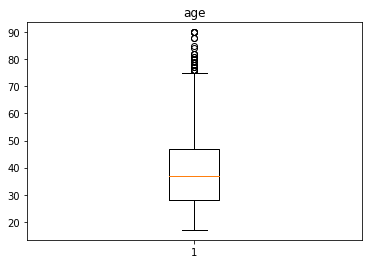

ATRIBUTO: fnlwgt
MIN: 20308
MAX: 1184622
MÉDIA: 191077.2270933801
DESV PADRÃO: 108007.3309201763


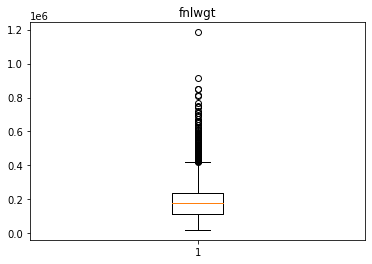

ATRIBUTO: educationNum
MIN: 1
MAX: 16
MÉDIA: 10.154537483559842
DESV PADRÃO: 2.530240304710453


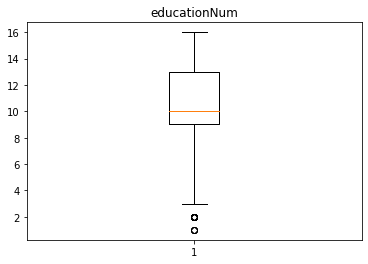

ATRIBUTO: capitalGain
MIN: 0
MAX: 99999
MÉDIA: 1210.446514686541
DESV PADRÃO: 8429.2193736789


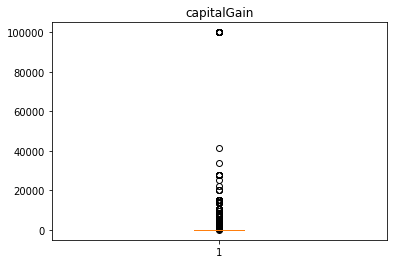

ATRIBUTO: capitalLoss
MIN: 0
MAX: 3683
MÉDIA: 96.14861902674265
DESV PADRÃO: 422.8195140060667


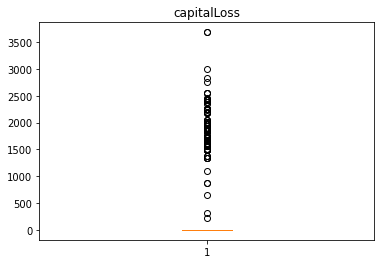

ATRIBUTO: hoursPerWeek
MIN: 2
MAX: 99
MÉDIA: 40.53726435773783
DESV PADRÃO: 11.861199062711092


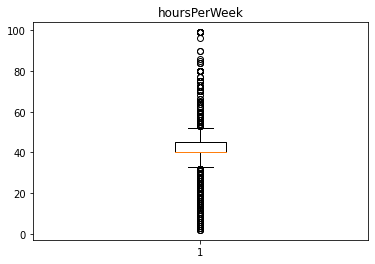

In [ ]:
#vizualizando caracterísicas dos atributos numéricos de ada_prior
numericos_ada_prior = ['age', 'fnlwgt', 'educationNum', 'capitalGain', 'capitalLoss', 'hoursPerWeek']

for atributo in numericos_ada_prior:
  print("ATRIBUTO: " + atributo)
  print("MIN: " + str(ada_prior[atributo].min()))
  print("MAX: " + str(ada_prior[atributo].max()))
  print("MÉDIA: " + str(ada_prior[atributo].mean()))
  print("DESV PADRÃO: "+ str(ada_prior[atributo].std()))
  plt.boxplot(ada_prior[atributo])
  plt.title(atributo)
  plt.show()

### **Identificar portadores de uma doença genética rara**

1. Número da observação
2. Número de identificação do hospital para amostra de sangue
3. Idade do paciente
4. Data em que se tirou sangue (mmddyy)
5. ml (1ª medição) sss.s
6. m2 (2ª medição) xxx.x
7. m3 (3ª medição) xxx.x
8. m4 (4ª medição) xxx Seven missing data points.
9. Portador ou não portador de doença rara

In [ ]:
biomed.head(10)


,Observation_number,Hospital_identification_number_for_blood_sample,Age_of_patient,Date_that_blood_sample_was_taken,ml,m2,m3,m4,class
0,1,923,31,60078,657.0,104.0,110.0,358.0,carrier
1,1,825,30,110078,22.0,91.0,17.5,198.0,normal
2,1,949,42,80078,78.0,118.0,15.5,212.0,carrier
3,1,895,23,10078,40.0,83.0,15.2,205.0,normal
5,1,941,31,40079,34.0,92.7,7.9,140.0,normal
6,3,1300,33,100079,43.0,88.5,20.3,175.0,normal
7,1,767,22,60078,48.0,76.0,16.6,133.0,normal
8,3,1398,39,90079,148.0,105.2,18.8,221.0,carrier
9,1,1285,25,90079,72.0,80.5,12.0,225.0,normal
10,1,978,35,90078,129.0,93.1,18.3,188.0,carrier


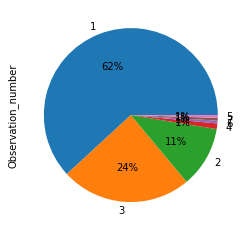

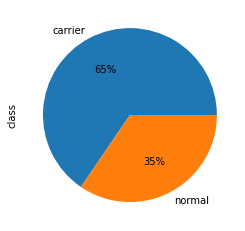

In [ ]:
#vizualizando distribuição dos atributos nominais de biomed
nominal_biomed = ['Observation_number', 'class']

for atributo in nominal_biomed:
  data = biomed[atributo].unique()
  plt.figure(figsize=(4,4))
  biomed[atributo].value_counts().plot.pie(labels = data, autopct='%1.0f%%')
  #plt.legend(loc="best")
  plt.show() 

ATRIBUTO: Age_of_patient
MIN: 20
MAX: 61
MÉDIA: 32.123711340206185
DESV PADRÃO: 8.561581535123347


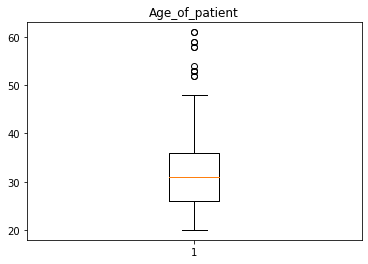

ATRIBUTO: ml
MIN: 15.0
MAX: 1288.0
MÉDIA: 90.09948453608247
DESV PADRÃO: 150.64037348627778


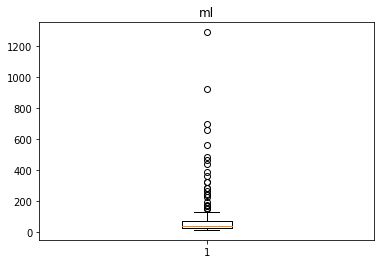

ATRIBUTO: m2
MIN: 34.0
MAX: 118.0
MÉDIA: 85.97628865979381
DESV PADRÃO: 12.516768219980769


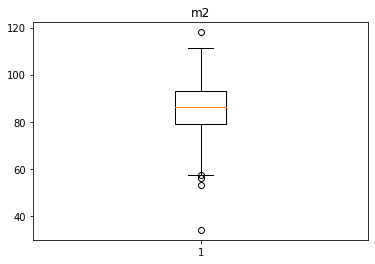

ATRIBUTO: m3
MIN: 2.8
MAX: 110.0
MÉDIA: 16.21649484536082
DESV PADRÃO: 12.062172107062137


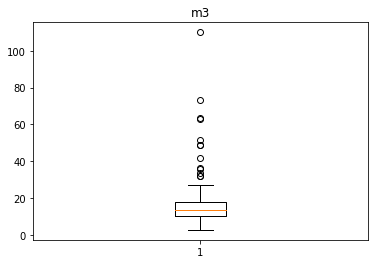

ATRIBUTO: m4
MIN: 66.0
MAX: 438.0
MÉDIA: 194.4020618556701
DESV PADRÃO: 67.87281000294327


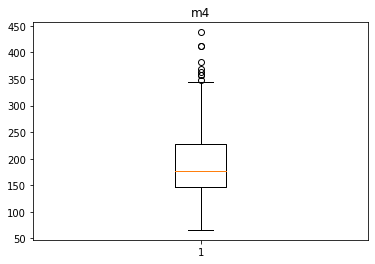

In [ ]:
#vizualizando caracterísicas dos atributos numéricos de biomed
numericos_biomed = ['Age_of_patient', 'ml','m2','m3','m4'] 

for atributo in numericos_biomed:
  print("ATRIBUTO: " + atributo)
  print("MIN: " + str(biomed[atributo].min()))
  print("MAX: " + str(biomed[atributo].max()))
  print("MÉDIA: " + str(biomed[atributo].mean()))
  print("DESV PADRÃO: "+ str(biomed[atributo].std()))
  plt.boxplot(biomed[atributo])
  plt.title(atributo)
  plt.show()

### **Pacientes hepáticos e não hepáticos na Índia**

1. Idade do paciente. Qualquer paciente cuja idade ultrapasse 89 anos é listado como tendo idade "90".
2. Gênero do paciente
3. Bilirrubina Total
4. Bilirrubina Direta
5. Alkphos Fosfatase Alcalina
6. Sgpt Alanina Aminotransferase
7. Sgot Aspartato Aminotransferase
8. Proteínas Totais
9. Albumina
10. Relação A/G Albumina e Relação Globulina

In [ ]:
ilpd.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,60,Male,0.7,0.2,171,31,26,7.0,3.5,1.000000,2
1,54,Female,1.4,0.7,195,36,16,7.9,3.7,0.900000,2
2,52,Male,0.6,0.1,178,26,27,6.5,3.6,1.200000,2
3,27,Male,1.0,0.3,180,56,111,6.8,3.9,1.850000,2
4,45,Male,20.2,11.7,188,47,32,5.4,2.3,0.700000,1
5,35,Female,0.6,0.2,180,12,15,5.2,2.7,0.947064,2
6,35,Male,0.7,0.2,198,42,30,6.8,3.4,1.000000,1
7,39,Male,1.9,0.9,180,42,62,7.4,4.3,1.380000,1
8,60,Male,0.8,0.2,286,21,27,7.1,4.0,1.200000,1
9,64,Male,3.0,1.4,248,46,40,6.5,3.2,0.900000,1


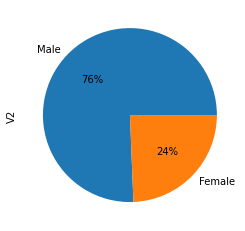

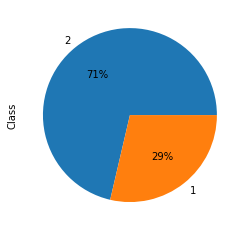

In [ ]:
#vizualizando distribuição dos atributos nominais de ilpd
nominal_ilpd = ['V2', 'Class']

for atributo in nominal_ilpd:
  data = ilpd[atributo].unique()
  plt.figure(figsize=(4,4))
  ilpd[atributo].value_counts().plot.pie(labels = data, autopct='%1.0f%%')
  #plt.legend(loc="best")
  plt.show() 

ATRIBUTO: V1
MIN: 4
MAX: 90
MÉDIA: 44.74614065180103
DESV PADRÃO: 16.18983330469438


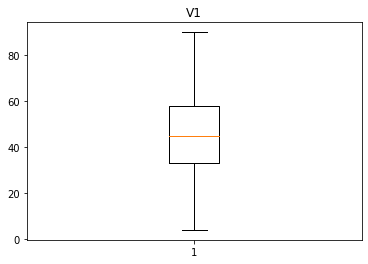

ATRIBUTO: V3
MIN: 0.4
MAX: 75.0
MÉDIA: 3.298799313893654
DESV PADRÃO: 6.2095217261801485


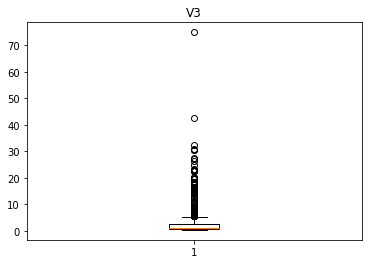

ATRIBUTO: V4
MIN: 0.1
MAX: 19.7
MÉDIA: 1.4861063464837108
DESV PADRÃO: 2.808497617658962


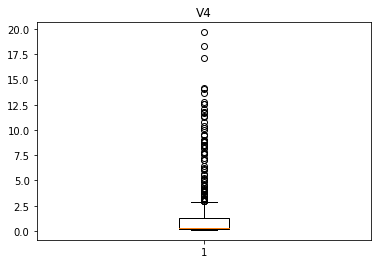

ATRIBUTO: V5
MIN: 63
MAX: 2110
MÉDIA: 290.57632933104634
DESV PADRÃO: 242.93798917934396


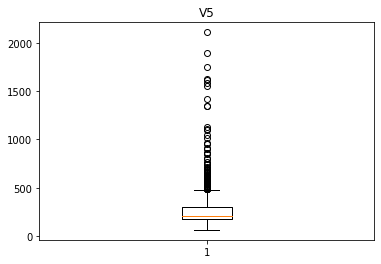

ATRIBUTO: V6
MIN: 10
MAX: 2000
MÉDIA: 80.71355060034305
DESV PADRÃO: 182.62035603420242


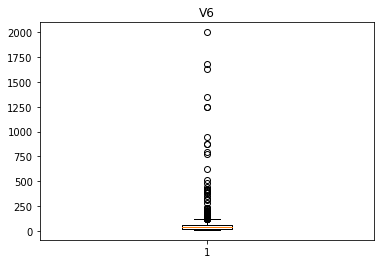

ATRIBUTO: V7
MIN: 10
MAX: 4929
MÉDIA: 109.91080617495712
DESV PADRÃO: 288.91852905173397


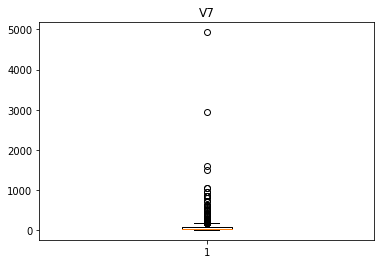

ATRIBUTO: V8
MIN: 2.7
MAX: 9.6
MÉDIA: 6.483190394511148
DESV PADRÃO: 1.085451484023467


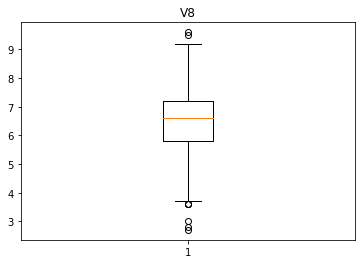

ATRIBUTO: V9
MIN: 0.9
MAX: 5.5
MÉDIA: 3.1418524871355076
DESV PADRÃO: 0.7955188059640264


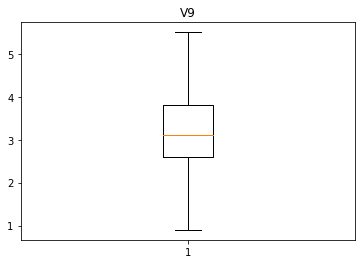

ATRIBUTO: V10
MIN: 0.3
MAX: 2.8
MÉDIA: 0.9470639039451116
DESV PADRÃO: 0.31849195945867437


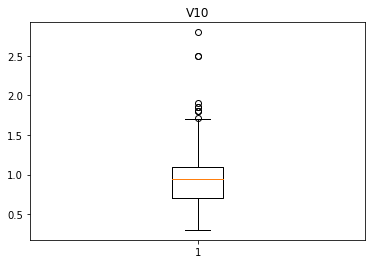

In [ ]:
#vizualizando caracterísicas dos atributos numéricos de ilpd
numericos_ilpd = ['V1', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10']

for atributo in numericos_ilpd:
  print("ATRIBUTO: " + atributo)
  print("MIN: " + str(ilpd[atributo].min()))
  print("MAX: " + str(ilpd[atributo].max()))
  print("MÉDIA: " + str(ilpd[atributo].mean()))
  print("DESV PADRÃO: "+ str(ilpd[atributo].std()))
  plt.boxplot(ilpd[atributo])
  plt.title(atributo)
  plt.show()

### **Dados de conclusão das fases escolares em escolas irlandesas**

1. Sexo: masculino; feminino.
2. DVRT (Drumcondra Verbal Reasoning Test Score).
3. Nível educacional alcançado.
4. Score de prestígio para a ocupação do pai (calculado por Raftery e Hout, 1985).
5. Tipo de escola: secundário; vocacional; primário.
6. Certificado de Saída.

In [ ]:
irish.head(10)

,Sex,DVRT,Educational_level,Prestige_score,Type_school,Leaving_Certificate
0,male,121,3rd_level_incomplete,37.0,secondary,taken
1,male,132,3rd_level_complete,37.0,secondary,taken
2,female,122,3rd_level_complete,38.0,secondary,taken
3,male,102,Junior_cycle_incomplete-secondary_school,18.0,secondary,not_taken
4,female,104,Senior_cycle_terminal_leaver-secondary_school,18.0,secondary,taken
5,female,94,Junior_cycle_terminal_leaver-secondary_school,37.0,secondary,not_taken
6,male,102,Junior_cycle_terminal_leaver-vocational_school,43.0,vocational,not_taken
7,male,91,Junior_cycle_terminal_leaver-secondary_school,40.0,secondary,not_taken
8,male,92,Junior_cycle_terminal_leaver-vocational_school,33.0,vocational,not_taken
9,female,92,Junior_cycle_incomplete-vocational_school,18.0,vocational,not_taken


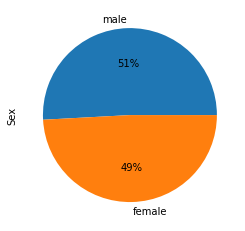

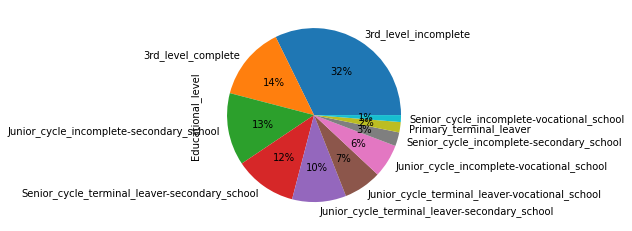

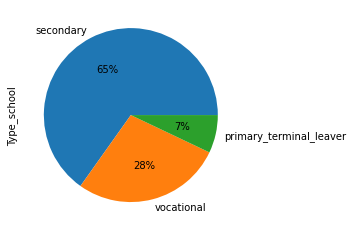

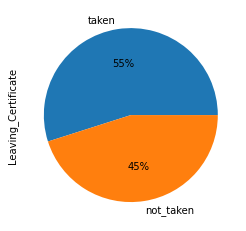

In [ ]:
#vizualizando distribuição dos atributos nominais de irish
nominal_irish = ['Sex', 'Educational_level', 'Type_school', 'Leaving_Certificate']

for atributo in nominal_irish:
  data = irish[atributo].unique()
  plt.figure(figsize=(4,4))
  irish[atributo].value_counts().plot.pie(labels = data, autopct='%1.0f%%')
  #plt.legend(loc="best")
  plt.show() 

ATRIBUTO: DVRT
MIN: 65
MAX: 140
MÉDIA: 99.98717948717949
DESV PADRÃO: 15.296213235667619


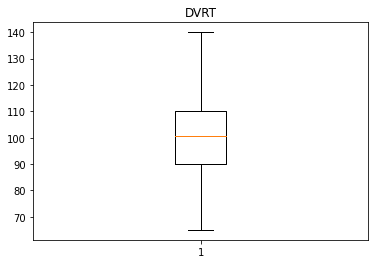

ATRIBUTO: Prestige_score
MIN: 18.0
MAX: 75.0
MÉDIA: 38.83974358974359
DESV PADRÃO: 15.254372825460184


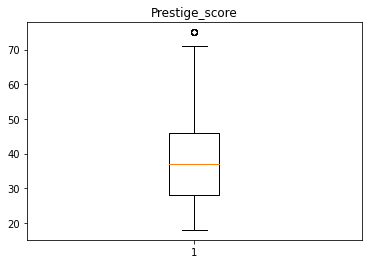

In [ ]:
#vizualizando caracterísicas dos atributos numéricos de irish
numericos_irish = ['DVRT','Prestige_score'] 

for atributo in numericos_irish:
  print("ATRIBUTO: " + atributo)
  print("MIN: " + str(irish[atributo].min()))
  print("MAX: " + str(irish[atributo].max()))
  print("MÉDIA: " + str(irish[atributo].mean()))
  print("DESV PADRÃO: "+ str(irish[atributo].std()))
  plt.boxplot(irish[atributo])
  plt.title(atributo)
  plt.show()

# **Separação em grupos de treino e teste**

In [ ]:
normalizador = MinMaxScaler(feature_range=(0,1))

"""
Cada elemento dos arrays abaixo será outro array com os conjuntos de treino e teste de cada dataset
"""
x_train = []
x_test = []
y_train = []
y_test = []

"""
Os dois arrays abaixo serão usados para armazenar os dados que continuaram rotulados,
e que serão passados para uma SVM, com o intuito de comparar a acurácia deste modelo
com as SVMs que vão utilizar mais dados obtidos com a imputação pelos algoritmos
"""
x_train_rotulado = [] 
y_train_rotulado = []

"""
O for a seguir percorre a lista de keys do dicionário de datasets, de forma que todas
as operações realizadas dentro do for são realizadas para todos os datasets
"""

for n,i in enumerate(list(datasets.keys())): 
  for column in datasets[i].columns:
    if(type(datasets[i][column][0]) == str): #se a coluna for composta por elementos do tipo string, aplica o LabelEncoder
      le = LabelEncoder()
      datasets[i][column] =  le.fit_transform(datasets[i][column]) #aplica o Labelencoder
  datasets[i] = normalizador.fit_transform(datasets[i]) #normaliza os dados em um intevalo de 0 a 1

  train_size = int(datasets[i].shape[0]*0.8) #define que o conjunto de treino será  80% do dataset
  x_train.append(datasets[i][0:train_size,0:(datasets[i].shape[1]-1)])  #coleta os atributos do conjunto de treino
  y_train.append(datasets[i][0:train_size,(datasets[i].shape[1]-1):]) #coleta os rótulos do conjunto de treino

  x_test.append(datasets[i][train_size:,0:(datasets[i].shape[1]-1)]) #coleta os atributos do conjunto de teste
  y_test.append(datasets[i][train_size:,(datasets[i].shape[1]-1):]) #coleta as classes do conjunto de teste

  #reshape para aplicar funções
  y_train[n] = (np.reshape(y_train[n],(y_train[n].shape[0]))) 
  y_test[n] = (np.reshape(y_test[n],(y_test[n].shape[0])))

  """
  Abaixo são escolhidos aleatoriamente 80% dos rótulos do conjunto de treino para serem retirados e subsituidos por -1,
  simulando uma situação de falta de dados rotulados.
  Tal operação faz com que 64% das instâncias do dataset não possuam rótulo
  """
  y_train[n][np.random.choice(y_train[n].shape[0], size=int(y_train[n].shape[0]*0.8), replace=False)] = -1 #retira label de 80% de y_train

  #separa somente os dados que foram rotulados para que sejam usados na SVM para o aprendizado supervisionado 
  x_train_rotulado.append(x_train[n][y_train[n] != -1])
  y_train_rotulado.append(y_train[n][y_train[n] != -1])



# **Teste só com dados rotulados**

In [ ]:
accuracy_supervised ={} #dicionario para guardar as acurácias da SVM supervisionada em cada dataset 
for i in range(0,len(x_train_rotulado)): 
  """
  Nessas SVMs, são utilizados SOMENTE OS DADOS ROTULADOS de cada dataset, ou seja,
  36% dos conjuntos de dados totais, para que seja possível verificar se a aplicação
  dos algorítimos de aprendizado semi-superviosionado valeu a pena ou não
  """
  model = SVC()
  model.fit(x_train_rotulado[i],y_train_rotulado[i])
  pred = model.predict(x_test[i])

  #acurácia de para cada dataset é colocada no dicionário com a key como o nome do dataset utilizado
  accuracy_supervised[list(datasets.keys())[i]]= accuracy_score(y_test[i],pred) 
print(accuracy_supervised)

{'quant_bank': 0.94, 'ada_prior': 0.8028477546549836, 'biomed': 0.8461538461538461, 'ilpd': 0.717948717948718, 'irish': 0.8297872340425532}


# **Algoritmos Semi-supervisionados**

## **Label Propagation**

In [ ]:
accuracy_lp = {} #dicionário que irá conter a acurácia das SVMs que usaram dados imputados pelo Label propagation
for n,i in enumerate(list(datasets.keys())):
  lp = LabelPropagation(max_iter=5000)
  lp.fit(x_train[n], y_train[n]) #treinamento do algoritmo semi-supervisionado com os dados não rotulados

  pred1 = lp.predict(x_test[n]) 

  print(i)
  #Verificação da acurácia da IMPUTAÇÃO realizado pelo Label Propagtion
  #ATENÇÃO! Essa acurácia não é a da SVM com os dados imputados, e sim da predição realizada pelo Label Propagation no conjunto de teste
  print(" Acurácia das imputações: " + str(accuracy_score(y_test[n], pred1))) 

  model = SVC()
  #Os labels faltantes de y_train são imputados pelo algoritmo, sendo todos os valores armazenados em y_tran_semi
  y_train_semi = lp.predict(x_train[n])
  """
    O if abaixo verifica se todos os dados foram imputados com um rótulo só, se sim 
    para acurácia no dataset é atribuido o valor None
  """
  if(len(np.unique(y_train_semi))==1): 
    print(" O Algoritmo semisupervisionado definiu todas as classes para um único valor")
    accuracy_lp[list(datasets.keys())[n]] = None
  else:
    model.fit(x_train[n],y_train_semi) #treina a SVM com os os dados obtidos com o algoritmo semisupervisionado
    pred = model.predict(x_test[n])
    
    ac = accuracy_score(y_test[n],pred) #calcula a acurácia da previsão da SVM treinada com os dados imputados pelo algoríimo

    accuracy_lp[list(datasets.keys())[n]] = ac #armazena a acurácia para seu respectivo dataset
print("SVM: ")
print(accuracy_lp) #mostra as acurácias obtidas com a SVM para todos os datasets

quant_bank
 Acurácia das imputações: 0.9
ada_prior
 Acurácia das imputações: 0.7962760131434831
biomed
 Acurácia das imputações: 0.7435897435897436
ilpd
 Acurácia das imputações: 0.7094017094017094
irish
 Acurácia das imputações: 0.8617021276595744
SVM: 
{'quant_bank': 0.88, 'ada_prior': 0.778751369112815, 'biomed': 0.717948717948718, 'ilpd': 0.717948717948718, 'irish': 0.8617021276595744}


## **Label Spreading**

In [ ]:
# This model is similar to the basic Label Propagation algorithm, but uses affinity matrix based 
# on the normalized graph Laplacian and soft clamping across the labels.

accuracy_ls = {} #dicionário que irá conter a acurácia das SVMs que usaram dados imputados pelo Label Spreading
for n,i in enumerate(list(datasets.keys())):
  ls = LabelSpreading(max_iter = 50) #treinamento do algorítimo semi-supervisionado com os dados não rotulados
  ls.fit(x_train[n], y_train[n])

  pred2 = ls.predict(x_test[n])
  print(i)
  #Verificação da acurácia da IMPUTAÇÃO realizado pelo Label Spreading
  #ATENÇÃO! Essa acurácia não é a da SVM com os dados imputados, e sim da predição realizada pelo Label Spreading no conjunto de teste
  print(" Acurácia das imputações: " + str(accuracy_score(y_test[n], pred2)))

  model = SVC()

  #Os labels faltantes de y_train são imputados pelo algorítimo, sendo todos os valores armazenados em y_tran_semi
  y_train_semi = ls.predict(x_train[n])
  """
    O if abaixo verifica se todos os dados foram imputados com um rótulo só, se sim 
    para acurácia no dataset é atribuido o valor None
  """
  if(len(np.unique(y_train_semi))==1):
    print("O Algoritmo semisupervisionado definiu todas as classes para um único valor")
    accuracy_ls[list(datasets.keys())[n]] = None
  else:
    model.fit(x_train[n],y_train_semi) #treina a SVM com os os dados obtidos com o algorímo semisupervisionado
    pred = model.predict(x_test[n])
    ac = accuracy_score(y_test[n],pred)#calcula a acurácia da previsão da SVM treinada com os dados imputados pelo algoríimo
    accuracy_ls[list(datasets.keys())[n]] = ac #armazena a acurácia para seu respectivo dataset
print("SVM: ")
print(accuracy_ls) #mostra as acurácias obtidas com a SVM para todos os datasets

quant_bank
 Acurácia das imputações: 1.0
ada_prior
 Acurácia das imputações: 0.8061336254107339
biomed
 Acurácia das imputações: 0.8717948717948718
ilpd
 Acurácia das imputações: 0.6581196581196581
irish
 Acurácia das imputações: 0.9787234042553191
SVM: 
{'quant_bank': 0.98, 'ada_prior': 0.8105147864184009, 'biomed': 0.8461538461538461, 'ilpd': 0.6581196581196581, 'irish': 1.0}


## **Self Training Classifier**

In [ ]:
accuracy_st = {} #dicionário que irá conter a acurácia das SVMs que usaram dados imputados pelo Self Training
for n,i in enumerate(list(datasets.keys())):
  svc = SVC(probability=True, gamma="auto") #O classificador base a ser usado pelo self-training é uma SVM
  stc = SelfTrainingClassifier(svc,threshold=0.6)
  stc.fit(x_train[n], y_train[n]) #treinamento do algoritmo semi-supervisionado com os dados não rotulados
  
  pred3 = stc.predict(x_test[n])

  #accuracy_st.append(accuracy_score(y_test[n], pred4))
  print(i)
  #Verificação da acurácia da IMPUTAÇÃO realizado pelo Label Spreading
  #ATENÇÃO! Essa acurácia não é a da SVM com os dados imputados, e sim da predição realizada pelo Label Spreading no conjunto de teste
  print(" Acurácia das imputações: " + str(accuracy_score(y_test[n], pred3)))

  model = SVC()

  #Os labels faltantes de y_train são imputados pelo algoritmo, sendo todos os valores armazenados em y_tran_semi
  y_train_semi = stc.predict(x_train[n])
  """
  O if abaixo verifica se todos os dados foram imputados com um rótulo só, se sim 
  para acurácia no dataset é atribuido o valor None
  """
  if(len(np.unique(y_train_semi))==1):
    print("O Algoritmo semisupervisionado definiu todas as classes para um único valor")
    accuracy_st[list(datasets.keys())[n]] = None
  else:
    model.fit(x_train[n],y_train_semi) #treina a SVM com os os dados obtidos com o algorímo semisupervisionado
    pred = model.predict(x_test[n]) 
    ac = accuracy_score(y_test[n],pred) #calcula a acurácia da previsão da SVM treinada com os dados imputados pelo algoríimo
    accuracy_st[list(datasets.keys())[n]] = ac #armazena a acurácia para seu respectivo dataset
print("SVM: ")
print(accuracy_st) #mostra as acurácias obtidas com a SVM para todos os datasets

quant_bank
 Acurácia das imputações: 0.7
ada_prior
 Acurácia das imputações: 0.8017524644030668
biomed
 Acurácia das imputações: 0.8461538461538461
ilpd
 Acurácia das imputações: 0.717948717948718
O Algoritmo semisupervisionado definiu todas as classes para um único valor
irish
 Acurácia das imputações: 0.8191489361702128
SVM: 
{'quant_bank': 0.7, 'ada_prior': 0.8039430449069004, 'biomed': 0.7692307692307693, 'ilpd': None, 'irish': 0.8085106382978723}


## **Comparação**

In [ ]:

"""
Compara as métricas obtidas para cada dataset com cada um dos métodos.
A inclusão das acurácias obtidas com somente 34% dos dados usados para
o aprendizado supervisionado evidencia se vale a pena utilizar os algoritmos
de aprendizado supervisionado em cada dataset, ou não
"""
for n in list(datasets.keys()):
  print("*****", n.upper(), "*****")

  print("->Supervisionado: ", accuracy_supervised[n])
  print()
  print("-> Label Propagation:", accuracy_lp[n])
  print()
  print("-> Label Spreading:", accuracy_ls[n])
  print()
  print("-> Self Training:", accuracy_st[n])
  print()


***** QUANT_BANK *****
->Supervisionado:  0.94

-> Label Propagation: 0.88

-> Label Spreading: 0.98

-> Self Training: 0.7

***** ADA_PRIOR *****
->Supervisionado:  0.8028477546549836

-> Label Propagation: 0.778751369112815

-> Label Spreading: 0.8105147864184009

-> Self Training: 0.8039430449069004

***** BIOMED *****
->Supervisionado:  0.8461538461538461

-> Label Propagation: 0.717948717948718

-> Label Spreading: 0.8461538461538461

-> Self Training: 0.7692307692307693

***** ILPD *****
->Supervisionado:  0.717948717948718

-> Label Propagation: 0.717948717948718

-> Label Spreading: 0.6581196581196581

-> Self Training: None

***** IRISH *****
->Supervisionado:  0.8297872340425532

-> Label Propagation: 0.8617021276595744

-> Label Spreading: 1.0

-> Self Training: 0.8085106382978723



# **Conclusão**
Como pode ser visto nas acurácias obtidas em cada um dos datasets, o uso de Label Spreding se mostrou vantajoso em 3 (quant_bank, ada_prior e biomed) dos 5 datasets utilizados, demostrando que a investigação a respeito do uso de técnincas de aprendizado semi-supervisionado vale a pena para alguns conjuntos de dados.
Também é observável que o algorítimo Self Training não performou muito bem para os datasets testados, tendo inclusive atribuído somente um rótulo para o dataset ilpd (que possui classes desbalanceadas), demostrando que o uso deste algoríitmo não é recomendado quando o dataset utilizado possui classes desbalanceadas.

Obs: Devido a aleatoriedade da exclusão dos rótulos dos datasets, tais resultados podem variar um pouco, mas execuções anteriores demonstraram resultados similares aos exibidos acima.